# Building a RAG APP
**Retrieval-Augmented Generation (RAG)** is a powerful NLP framework that combines a retrieval-based approach with generative models like GPT or BERT-based transformers. Instead of generating answers based solely on a model's internal knowledge, RAG retrieves relevant documents from an external knowledge base (like a vector store) and uses them to produce more accurate, grounded, and up-to-date responses

##  Objective
This code builds a RAG pipeline that indexes documents, retrieves relevant context for a user query, and generates accurate answers using a language model.



##  Setup

In [ ]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph langchain-nvidia-ai-endpoints

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.2/148.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 13.5 MB/s eta 0:00:00


In [ ]:
import getpass
import os

# Set up your api key
if not os.environ.get("NVIDIA_API_KEY"):
  os.environ["NVIDIA_API_KEY"] = getpass.getpass("Enter API key for NVIDIA: ")

Enter API key for NVIDIA: ··········


In [ ]:
from langchain.chat_models import init_chat_model
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

# Select the chat model
llm = init_chat_model('meta/llama-3.1-70b-instruct', model_provider = 'nvidia')

# Select the embedding model
embeddings = NVIDIAEmbeddings(model='NV-Embed-QA')

In [ ]:
# Select vectstore
from langchain_core.vectorstores import InMemoryVectorStore

vect_store = InMemoryVectorStore(embeddings)

##  Complete Preview

In [ ]:
import bs4
from bs4 import SoupStrainer
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load the blog post

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

docs = loader.load()

In [ ]:
# split into smaller chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
docs = text_splitter.split_documents(docs)

# Index the chunks
_ = vect_store.add_documents(docs)

In [ ]:
# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

# Define state
class State(TypedDict):
  question: str
  context: List[Document]
  answer: str

def retriver(state: State):
  retrieved_docs = vect_store.similarity_search(state['question'])
  return {'context': retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:280: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [ ]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([retriver, generate])
graph_builder.add_edge(START, "retriver")
graph = graph_builder.compile()

In [ ]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task decomposition is the process of breaking down a large, complex task into smaller, manageable subgoals, enabling efficient handling of the task. It can be done through various methods, including simple prompting, task-specific instructions, or with human inputs. This process is a key component of planning in a autonomous agent system, allowing the agent to plan ahead and handle complicated tasks.


## 1. Indexing

### Loading Documents

In [ ]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Focus only on <article> tags (or adapt if Medium uses different structure)
bs4_strainer = SoupStrainer(["article", "h1", "h2", "h3", "p", "title"])

loader = WebBaseLoader(
    web_paths=("https://medium.com/@aakuskar.980/what-is-the-model-context-protocol-mcp-f6e287d62adc",),
    bs_kwargs={"parse_only": bs4_strainer},
)

docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 8193


In [ ]:
print(docs[0].page_content[:500])

What is the Model Context Protocol (MCP)? | by Aditya Ak | Mar, 2025 | MediumSign upSign inSign upSign inWhat is the Model Context Protocol (MCP)?Aditya AkFollow5 min read·Mar 24, 2025--ListenShareIn the rapidly evolving world of AI, the Model Context Protocol (MCP) is gaining attention for a good reason. It acts as a communication bridge between AI models and external systems, enabling AI assistants to directly interact with various services. This creates new possibilities for AI applications t


### Splitting Documents

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50, add_start_index=True)
docs = text_splitter.split_documents(docs)

print(f'Total chunks: {len(docs)}')

Total chunks: 35


### Storing documents

In [ ]:
document_ids = vect_store.add_documents(documents=docs)

print(document_ids[:3])

['274988d2-aaf8-4ffa-887e-9e652979dc27', '5133035c-53b5-44f9-8441-b97b6c488bfb', 'd4ed40a8-3abc-44e3-b367-2d7338ed9e4e']


## 2. Retrieval and Generation

In [ ]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:280: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [ ]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [ ]:
def retrieve(state: State):
    retrieved_docs = vect_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [ ]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

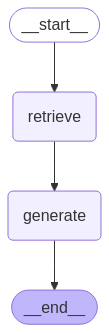

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
result = graph.invoke({"question": "What is MCP?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='b9713bfd-01ca-4475-af98-21277b9c908b', metadata={'source': 'https://medium.com/@aakuskar.980/what-is-the-model-context-protocol-mcp-f6e287d62adc', 'title': 'What is the Model Context Protocol (MCP)? | by Aditya Ak | Mar, 2025 | Medium', 'start_index': 761}, page_content='in AI integration. By providing a universal interface, it allows AI models to break free from their limitations and interact with external tools and data. With its flexible, secure, and scalable design, MCP makes it easier for developers'), Document(id='40dc8a6d-2f15-426f-8d08-e6e762a7c34a', metadata={'source': 'https://medium.com/@aakuskar.980/what-is-the-model-context-protocol-mcp-f6e287d62adc', 'title': 'What is the Model Context Protocol (MCP)? | by Aditya Ak | Mar, 2025 | Medium', 'start_index': 761}, page_content='in AI integration. By providing a universal interface, it allows AI models to break free from their limitations and interact with external tools and data. With its flexible, secur

In [ ]:
for step in graph.stream(
    {"question": "What is MCP?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='b9713bfd-01ca-4475-af98-21277b9c908b', metadata={'source': 'https://medium.com/@aakuskar.980/what-is-the-model-context-protocol-mcp-f6e287d62adc', 'title': 'What is the Model Context Protocol (MCP)? | by Aditya Ak | Mar, 2025 | Medium', 'start_index': 761}, page_content='in AI integration. By providing a universal interface, it allows AI models to break free from their limitations and interact with external tools and data. With its flexible, secure, and scalable design, MCP makes it easier for developers'), Document(id='40dc8a6d-2f15-426f-8d08-e6e762a7c34a', metadata={'source': 'https://medium.com/@aakuskar.980/what-is-the-model-context-protocol-mcp-f6e287d62adc', 'title': 'What is the Model Context Protocol (MCP)? | by Aditya Ak | Mar, 2025 | Medium', 'start_index': 761}, page_content='in AI integration. By providing a universal interface, it allows AI models to break free from their limitations and interact with external tools and data. With its

In [ ]:
for message, metadata in graph.stream(
    {"question": "What is MCP?"}, stream_mode="messages"
):
    print(message.content, end="|")

|M|CP| (|Model|-|agnostic| Communication| Protocol|)| is| a| universal| interface| that| enables| AI| models| to| interact| with| external| tools| and| data|,| breaking| free| from| their| limitations|.| It| operates| on| a| client|-server| architecture|,| allowing| AI| applications| or| interfaces| (|M|CP| Host|s|)| to| access| data| through| MCP|.| This| enhances| the| functionality| and| applic|ability| of| language| models|.||

## Prompt Customizing


In [ ]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [ ]:
total_documents = len(docs)
third = total_documents // 3

for i, document in enumerate(docs):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


docs[0].metadata

{'source': 'https://medium.com/@aakuskar.980/what-is-the-model-context-protocol-mcp-f6e287d62adc',
 'title': 'What is the Model Context Protocol (MCP)? | by Aditya Ak | Mar, 2025 | Medium',
 'start_index': 0,
 'section': 'beginning'}

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(docs)

In [ ]:
from typing import Literal

from typing_extensions import Annotated
from pydantic import BaseModel, Field


class Search(BaseModel):
    """Search query."""

    query: Annotated[str, Field(..., description="Search query to run.")]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        Field(..., description="Section to query."),
    ]

In [ ]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query.query,  # Access the query attribute using dot notation
        filter=lambda doc: doc.metadata.get("section") == query.section,  # Access the section attribute using dot notation
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

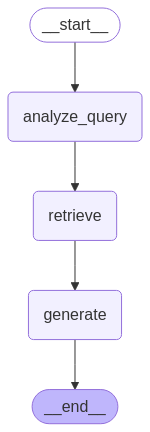

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
for step in graph.stream(
    {"question": "What does the end of the post say about MCP?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': Search(query='What does the end of the post say about MCP?', section='middle')}}

----------------

{'retrieve': {'context': [Document(id='191a858e-e417-4332-b829-b16993388a84', metadata={'source': 'https://medium.com/@aakuskar.980/what-is-the-model-context-protocol-mcp-f6e287d62adc', 'title': 'What is the Model Context Protocol (MCP)? | by Aditya Ak | Mar, 2025 | Medium', 'start_index': 0, 'section': 'middle'}, page_content='Enables language models to use external tools, enhancing their functionality and applicability.How Does MCP Work?MCP operates on a client-server architecture:MCP Hosts: These are the AI applications or interfaces, such as IDEs, or AI tools, that seek to access data through MCP. They initiate'), Document(id='eea362c8-e4cd-4500-a34c-c784bb3b7c67', metadata={'source': 'https://medium.com/@aakuskar.980/what-is-the-model-context-protocol-mcp-f6e287d62adc', 'title': 'What is the Model Context Protocol (MCP)? | by Aditya Ak | Mar, 2025 | Mediu